## Covid-Xray Pipeline Deployment in UCS

### Clone git repo

In [ ]:
! git clone -b dev https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

In [ ]:
! pip install kfp --user

### Import libraries

In [1]:
import kfp
import os
from kubernetes import client
import calendar
import time
import numpy as np

### Component files Declarations

In [2]:
 path = 'cisco-kubeflow-starter-pack/apps/healthcare/covid/onprem/pipelines/chest-xray/' 
component_root_download= path + 'components/v2/download_dataset/'
component_root_katib= path + 'components/v2/tf-katib-deploy-service/'
component_root_train= path + 'components/v2/tf-model-train/'
component_root_serve = path + 'components/v2/tf-serving-deploy-service/'

#### Components Description

tf_train_model_op &nbsp;&nbsp;&nbsp; - &nbsp; Load dataset from nfs-volume, train Covid Xray model  and save model in nfs-volume. <br> 
tf_serve_model_op &nbsp; - &nbsp; Load Covid Xray model from nfs-volume and serve the model using tf-serving for later prediction. <br> 


### Load components from respective .YAML config files

In [3]:
tf_download_dataset_op = kfp.components.load_component_from_file(os.path.join(component_root_download, 'component.yaml'))
tf_katib = kfp.components.load_component_from_file(os.path.join(component_root_katib, 'component.yaml'))
tf_train_model_op = kfp.components.load_component_from_file(os.path.join(component_root_train, 'component.yaml')) 
tf_serve_model_op = kfp.components.load_component_from_file(os.path.join(component_root_serve, 'component.yaml'))

### Define Volume and Volume Mounts

In [4]:
nfs_pvc = client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs')
nfs_volume = client.V1Volume(name='nfs', persistent_volume_claim=nfs_pvc)
nfs_volume_mount = client.V1VolumeMount(mount_path='/mnt/', name='nfs')

### Define pipeline function

In [5]:
# Creating timestamp
timestamp = str(calendar.timegm(time.gmtime()))
print(timestamp)
def covid_pipeline():
    
#     Defining Task for downloading dataset
    tf_download_task = tf_download_dataset_op()
    tf_download_task.add_volume(nfs_volume)
    tf_download_task.add_volume_mount(nfs_volume_mount)
    
#     Defining Task for katib hyperparameter values
    tf_katib_task = tf_katib(timestamp=timestamp,image="docker.io/edward1723/katib-trial:0.4")
    tf_katib_task.add_volume(nfs_volume)
    tf_katib_task.add_volume_mount(nfs_volume_mount)
    tf_katib_task.after(tf_download_task)
        
# #     Defining Task for Model training
    tf_train_model_task = tf_train_model_op(timestamp=timestamp)
    tf_train_model_task.add_volume(nfs_volume)
    tf_train_model_task.add_volume_mount(nfs_volume_mount)
    tf_train_model_task.after(tf_katib_task)
    
#     Defining Task to perform serving    
    tf_serve_model_task = tf_serve_model_op(timestamp=timestamp)
    tf_serve_model_task.add_volume(nfs_volume)
    tf_serve_model_task.add_volume_mount(nfs_volume_mount)
    tf_serve_model_task.after(tf_train_model_task)
    
#Creating a pipeline run
kfp.Client().create_run_from_pipeline_func(covid_pipeline, arguments={})

1599020024


RunPipelineResult(run_id=ae45ef0c-914d-4463-8feb-f80d9f1aa5b7)

###  Prediction with TF Serving

Xray result :  NORMAL


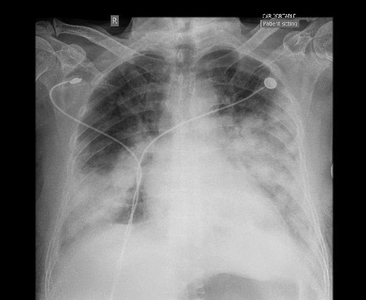

In [28]:
## TF Serving
import tensorflow
import requests, json
import numpy as np
from PIL import Image
test_image_path = 'katib_data/normal/08ed451c576ee00935ee178ec85c57_jumbo-1.jpeg'
sess = tensorflow.keras.backend.get_session()
img = tensorflow.read_file(test_image_path)
img = tensorflow.image.decode_jpeg(img, channels=3)
img.set_shape([None, None, 3])
img = tensorflow.image.resize_images(img, (224, 224))
img = img.eval(session=sess) # convert to numpy array
img = np.expand_dims(img, 0) # make 'batch' of 1

headers = {"content-type": "application/json"}
data={"signature_name": "serving_default", "instances": img.tolist()}
json_response = requests.post('http://10.96.18.13:8500/v1/models/Model_Covid:predict', data=json.dumps(data), headers=headers)
prediction=json_response.json()['predictions']
labels=[1,0]
pred = labels[np.argmax(prediction)]
diction = {'0':'NORMAL','1':'COVID'}
result = diction[str(pred)]
print('Xray result : ',result)

baseheight = 300
img_output = Image.open(test_image_path)
hpercent = (baseheight / float(img_output.size[1]))
wsize = int((float(img_output.size[0]) * float(hpercent)))
img_res = img_output.resize((wsize, baseheight), PIL.Image.ANTIALIAS)
img_res